## Time Series Pred: International Airline Passenger Data
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

** Dataset Information: **

144 observations from January 1949 to December 1960 or 12 years

** Attribute Information: **

International airline passengers: monthly totals in thousands

** Objective of this project **

predict the number of international airline passengers in units of 1,000

## Data

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
warnings.filterwarnings('ignore')

# Load Data
df = pd.read_csv('airline_passengers.csv')
df.head()

,Month,Thousands of Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [3]:
df.tail()

,Month,Thousands of Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


### Data Clean

In [4]:
# clean data
df.drop(144,axis=0,inplace=True)
df['Month'] = pd.to_datetime(df['Month'])
df.columns = ['Month','Thousands of Passengers']
df.set_index('Month',inplace=True)
df.tail()

,Thousands of Passengers
Month,
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0
1960-11-01,390.0
1960-12-01,432.0


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Thousands of Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


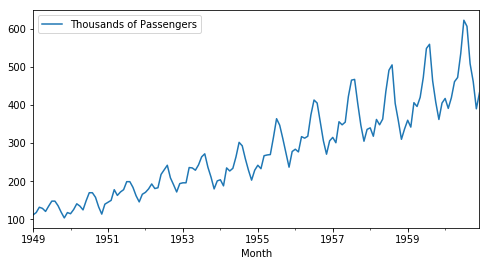

In [6]:
df.plot(figsize=(8,4))

### ETS Decomposition

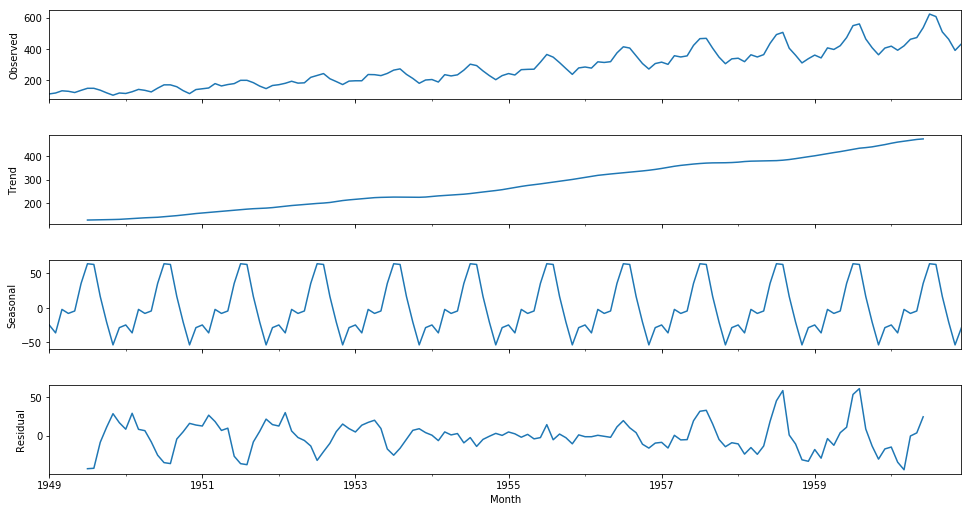

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Thousands of Passengers'], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

### Stationary Data

In [8]:
# Augmented Dickey-Fuller test 
from statsmodels.tsa.stattools import adfuller
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
        
adf_check(df['Thousands of Passengers'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : 0.815368879206
p-value : 0.991880243438
#Lags Used : 13
Number of Observations Used : 130
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.82926682417
p-value : 0.0542132902838
#Lags Used : 12
Number of Observations Used : 130
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


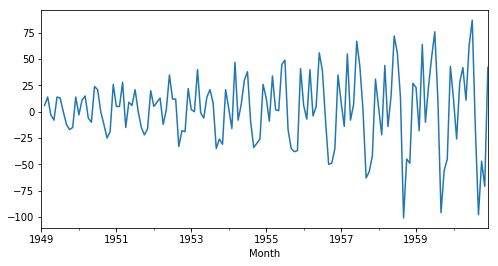

In [10]:
# First Difference
df['Passenger First Difference'] = df['Thousands of Passengers'] - df['Thousands of Passengers'].shift(1)
df['Passenger First Difference'].plot(figsize=(8,4))
adf_check(df['Passenger First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -15.5956180837
p-value : 1.85651160012e-28
#Lags Used : 0
Number of Observations Used : 130
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


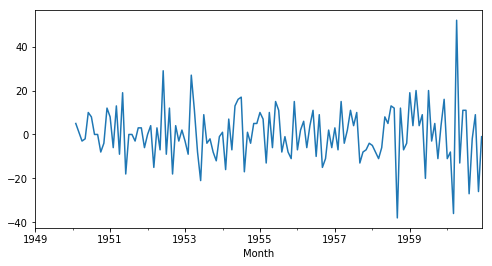

In [11]:
# Seasonal First Difference
df['Seasonal First Difference'] = df['Passenger First Difference'] - df['Passenger First Difference'].shift(12)
df['Seasonal First Difference'].plot(figsize=(8,4))
adf_check(df['Seasonal First Difference'].dropna())

### Autoregression

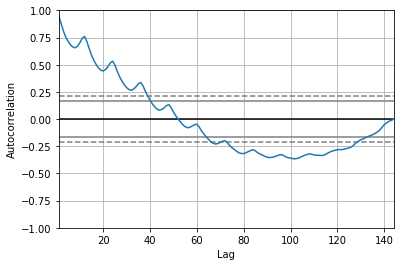

In [12]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Thousands of Passengers'])

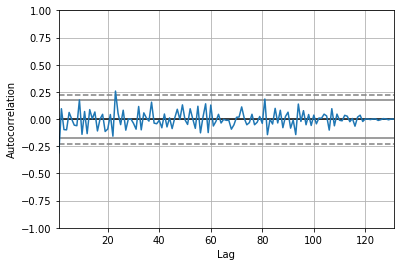

In [13]:
autocorrelation_plot(df['Seasonal First Difference'].dropna())

## Persistence Model (baseline)


Test MSE: 2825.083


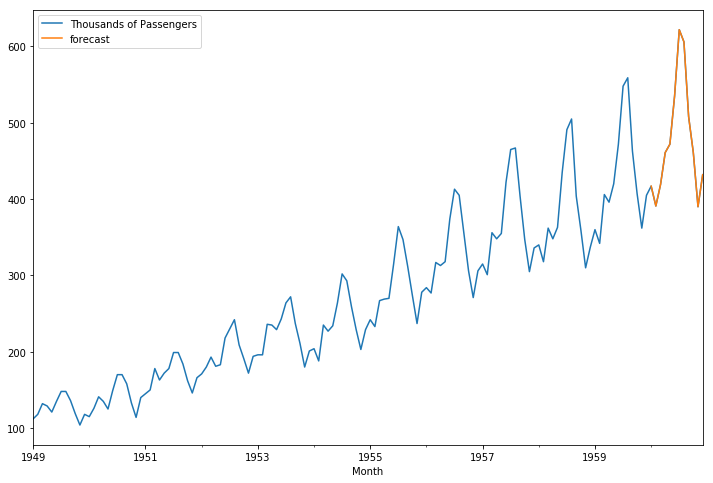

In [15]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline
warnings.filterwarnings('ignore')

# Load & Clean Data
df = pd.read_csv('airline_passengers.csv')
df.drop(144,axis=0,inplace=True)
df['Month'] = pd.to_datetime(df['Month'])
df.columns = ['Month','Thousands of Passengers']
df.set_index('Month',inplace=True)
#print(df.head())

# Data Preprocessing
#lagged dataset
df['Thousands of Passengers, t-1'] = df['Thousands of Passengers'].shift(1)
df['Thousands of Passengers cow, t+1'] = df['Thousands of Passengers']
#print(df.head()) 

#train test set
X = df.values
train, test = X[1:-12], X[-12:]
X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

# Persistence model
def model_persistence(x):
    return x

# Make predictions & Evaluate model
y_pred = list()
for x in X_test:
    yhat = model_persistence(x)
    y_pred.append(yhat)
test_score = mean_squared_error(y_test, y_pred)
print('\nTest MSE: %.3f' % test_score)

# Visualize results
df['forecast'] = np.nan
df['forecast'][-12:]  = y_pred
#df.tail(13)
df[['Thousands of Passengers','forecast']].plot(figsize=(12,8))

## Autoregressive Integrated Moving Average (ARIMA) Model

                                 Statespace Model Results                                 
Dep. Variable:            Thousands of Passengers   No. Observations:                  132
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -450.029
Date:                            Sat, 03 Mar 2018   AIC                            906.059
Time:                                    22:50:34   BIC                            914.707
Sample:                                01-01-1949   HQIC                           909.573
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9997      0.184     -5.434      0.000      -1.360      -0.639
ma.S.L12       0.9922      2.332   

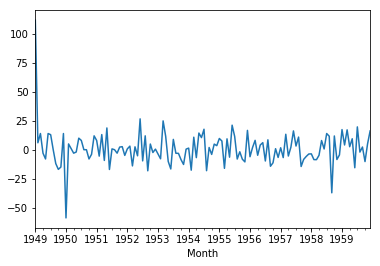

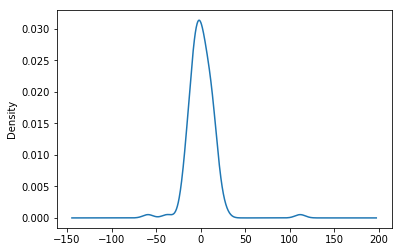

In [16]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
warnings.filterwarnings('ignore')

# Load & Clean Data
df = pd.read_csv('airline_passengers.csv')
df.drop(144,axis=0,inplace=True)
df['Month'] = pd.to_datetime(df['Month'])
df.columns = ['Month','Thousands of Passengers']
df.set_index('Month',inplace=True)
#print(df.head())

# Fit seasonal ARIMA model
#from statsmodels.tsa.arima_model import ARIMA #--> for non-seasonal data
model = sm.tsa.statespace.SARIMAX(df['Thousands of Passengers'][:-12],
                                  order=(0,1,0), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())
results.resid.plot()
plt.show()
results.resid.plot(kind='kde')
plt.show()

Test MSE: 525.616


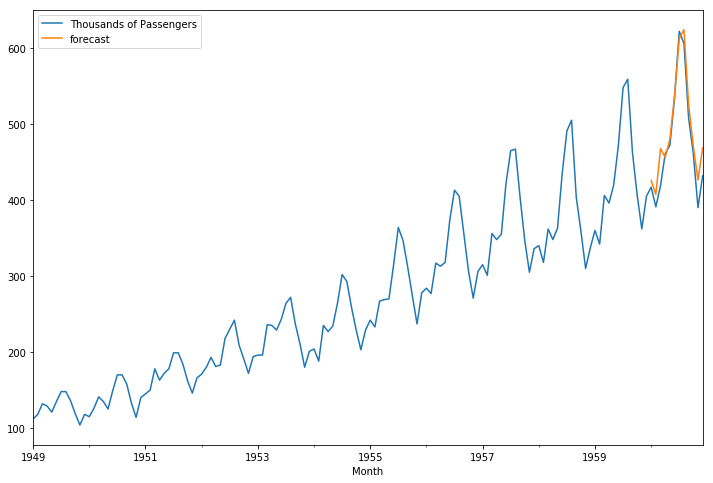

In [18]:
# forecast
df['forecast'] = results.predict(start = 132, end= 144, dynamic= True)  
df[['Thousands of Passengers','forecast']].plot(figsize=(12,8))
df.tail(13)
# rmse
error = mean_squared_error(df['Thousands of Passengers'][-12:],
                           df['forecast'][-12:])
print('Test MSE: %.3f' % error)